In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import madx.particles_trajectory_generator as ptg
import importlib as il
import data.bunch_configuration as buc
import madx.madx_configuration as mc
il.reload(ptg)
sns.set(style="whitegrid")
sys.path.append("/home/rafalmucha/Pobrane/optic/optics_generator_python/src")
path_to_configuration = "/home/rafalmucha/Pobrane/optic/2017/"
path_to_xml_file = "/home/rafalmucha/Pobrane/optic/2017/configuration_reco_beam1.xml"
item_number = 2
madx_configuration = mc.MadxConfiguration(path_to_xml_file, item_number, path_to_configuration)

In [2]:
# Parameters of bunch
x_mean = 0.0
sigma_x = 0
theta_x_mean = 1.5e-4
sigma_theta_x = 0.00000
y_mean = -1.5e-3
sigma_y = 0
theta_y_mean = 0.00
sigma_theta_y = 0.00000
pt_mean = -0.0
sigma_pt = 1e-2

particles_number = 1

In [3]:
bunch_configuration = buc.BunchConfiguration.from_sigma(x_mean, sigma_x, particles_number,
                                                        theta_x_mean, sigma_theta_x, 1,
                                                        y_mean, sigma_y, 1,
                                                        theta_y_mean, sigma_theta_y, 1,
                                                        pt_mean, sigma_pt, 1)

In [4]:
output = ptg.generate_random_particles(madx_configuration, bunch_configuration, particles_number)

index -1 is out of bounds for axis 0 with size 0
index -1 is out of bounds for axis 0 with size 0
index -1 is out of bounds for axis 0 with size 0


In [5]:
output["end"]

array([[ 1.00000000e+00,  1.00000000e+00,  5.12775110e-04,
        -7.35805659e-07,  3.31328083e-03, -1.54108443e-05,
         0.00000000e+00, -6.76708265e-03,  2.19550000e+02,
         6.50000000e+03]])

In [6]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output[start_segment_name].T[1] -= 1
    
non_filtered_input_matrix = output[start_segment_name]
output_matrix = output[end_segment_name]
indexes = output_matrix.T[0].astype(int) - 1
input_matrix = output[start_segment_name][indexes]

In [7]:
def generate_dataset(x_name, x_index, y_name, y_index, input_raw, input_filtered, output, x_multiplier, y_multiplier):
    turn_name = "turn"
    turn_index = 1
    
    x_in_raw = input_raw.T[x_index] * x_multiplier
    y_in_raw = input_raw.T[y_index] * y_multiplier
    turn_in_raw = input_raw.T[turn_index].astype(int)

    frame_in_raw = pd.DataFrame(data={x_name: x_in_raw, y_name: y_in_raw, turn_name: turn_in_raw})

    turn_in = input_filtered.T[turn_index].astype(int)
    x_in = input_filtered.T[x_index] * x_multiplier
    y_in = input_filtered.T[y_index] * y_multiplier
    frame_in = pd.DataFrame(data={x_name: x_in, y_name: y_in, turn_name: turn_in})

    turn_out = output.T[turn_index].astype(int)
    x_out = output.T[x_index] * x_multiplier
    y_out = output.T[y_index] * y_multiplier
    frame_out = pd.DataFrame(data={x_name: x_out, y_name: y_out, turn_name: turn_out})

    data_frame = frame_in_raw.append(frame_out)
    data_frame = data_frame.append(frame_in)
    
    mapping = {-1: 'IN: all', 0: 'IN: which passed to OUT', 1: 'OUT'}
    frame_with_names = data_frame.replace({"turn": mapping})
    
    return frame_with_names

index_map = {
    "x": 2,
    "theta x": 3,
    "y": 4,
    "theta y": 5,
    "t": 6,
    "pt": 7,
    "s": 8,
    "e": 9,
    "alfa x": 10,
    "alfa y": 11
}
multiplier_for_unit = {
    "x": 1000,
    "theta x": 1000000,
    "y": 1000,
    "theta y": 10e6,
    "t": 1,
    "pt": 1
}
meters = " [mm]"
radians = " [µrad]"
seconds = " [s]"
energy = " [GeV]"
no_unit = " "
unit_map = {
    "x": meters,
    "theta x": radians,
    "y": meters,
    "theta y": radians,
    "t": seconds,
    "pt": no_unit,
    "s": meters,
    "e": energy,
    "alfa x": radians,
    "alfa y": radians
}


def find_min_and_max(x_name, y_name, matrixes):
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    matrix1 = matrixes[0]
    
    x_min = np.min(matrix1.T[x_index])
    y_min = np.min(matrix1.T[y_index])
    
    x_max = np.max(matrix1.T[x_index])
    y_max = np.max(matrix1.T[y_index])
    
    for matrix2 in matrixes[1:]:
        x_min = min(np.min(matrix2.T[x_index]), x_min)
        y_min = min(np.min(matrix2.T[y_index]), y_min)
        
        x_max = max(np.max(matrix2.T[x_index]), x_max)
        y_max = max(np.max(matrix2.T[y_index]), y_max)
    
    return x_min, x_max, y_min, y_max



def plot_with_turn(x_name, y_name, non_filtered_input_matrix, input_matrix, output_matrix, x_pos, y_pos, axes):
    title_sufix = "\n-all particles on input\n-only this which came to end station\n-particles at end station"
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    turn_name = "turn"
    turn_index = 1

    x_full_name = x_name + unit_map[x_name]
    y_full_name = y_name + unit_map[y_name]
    
    x_unit_multiplier = multiplier_for_unit[x_name]
    y_unit_multiplier = multiplier_for_unit[y_name]
    
    data_frame = generate_dataset(x_full_name, x_index, y_full_name, y_index, non_filtered_input_matrix, 
                                  input_matrix, output_matrix, x_unit_multiplier, y_unit_multiplier)

    title = x_name + " and " + y_name + " parameter:" + title_sufix
    
    matrixes = [non_filtered_input_matrix, input_matrix, output_matrix]
    
    x_min, x_max, y_min, y_max = find_min_and_max(x_name, y_name, matrixes)

    delta_x = x_max - x_min
    delta_y = y_max - y_min
    
    x_lower_axis_limit = (x_min - 0.25 * delta_x) * x_unit_multiplier
    x_upper_axis_limit = (x_max + 0.25 * delta_x) * x_unit_multiplier
    
    y_lower_axis_limit = (y_min - 0.25 * delta_y) * y_unit_multiplier
    y_upper_axis_limit = (y_max + 0.25 * delta_y) * y_unit_multiplier
    
    axes[x_pos][y_pos].set_xlim(x_lower_axis_limit, x_upper_axis_limit)
    axes[x_pos][y_pos].set_ylim(y_lower_axis_limit, y_upper_axis_limit)
    
    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=data_frame, ax=axes[x_pos][y_pos], hue="turn").set_title(title)

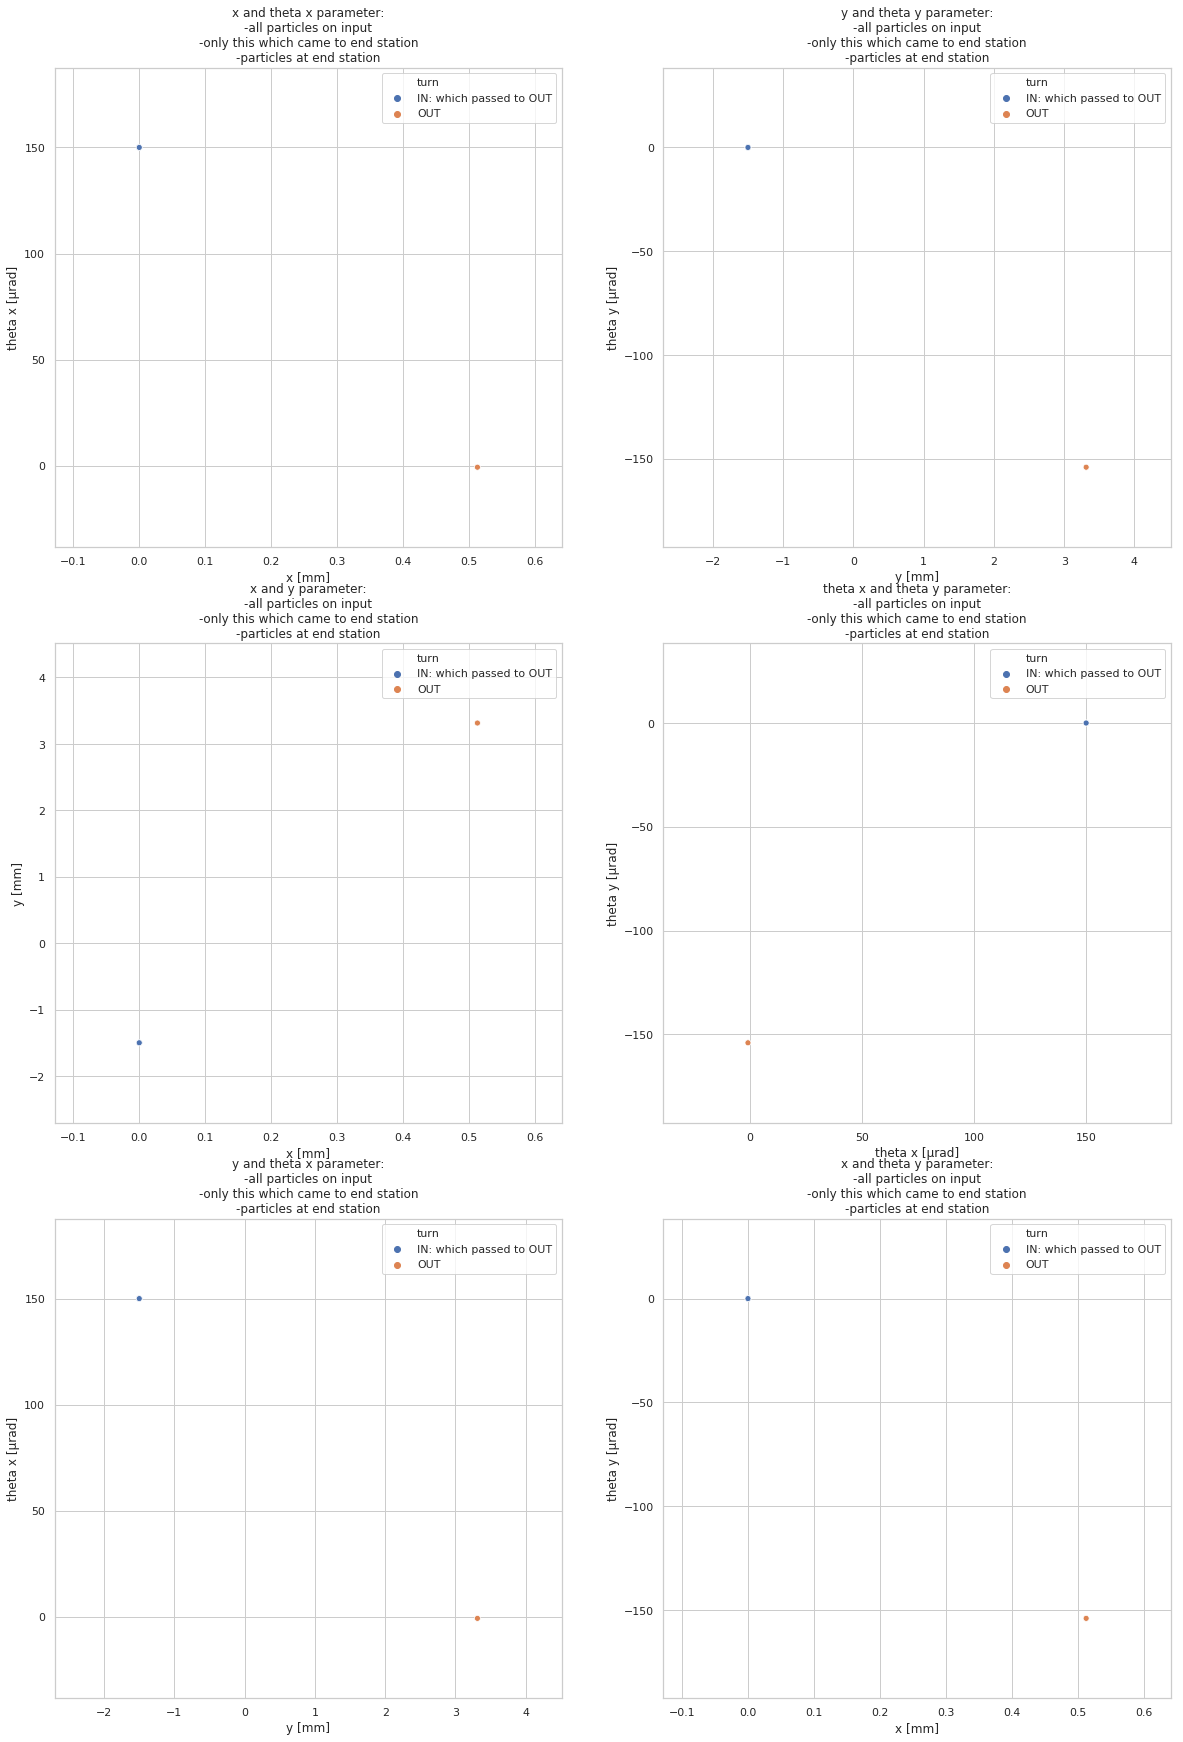

In [8]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot_with_turn("x", "theta x", non_filtered_input_matrix, input_matrix, output_matrix, 0, 0, axes)

plot_with_turn("y", "theta y", non_filtered_input_matrix, input_matrix, output_matrix, 0, 1, axes)

plot_with_turn("x", "y", non_filtered_input_matrix, input_matrix, output_matrix, 1, 0, axes)

plot_with_turn("theta x", "theta y", non_filtered_input_matrix, input_matrix, output_matrix, 1, 1, axes)

plot_with_turn("y", "theta x", non_filtered_input_matrix, input_matrix, output_matrix, 2, 0, axes)

plot_with_turn("x", "theta y", non_filtered_input_matrix, input_matrix, output_matrix, 2, 1, axes)



In [9]:
def plot(x_name, y_name, x_name_prefix, y_name_prefix, x_matrix, y_matrix, plot_axes, plot_x_pos, plot_y_pos):
    
    # Get names of axis and title of plot
    
    x_full_name = x_name_prefix + x_name + unit_map[x_name]
    y_full_name = y_name_prefix + y_name + unit_map[y_name]
    
    title = x_name_prefix + x_name + " and " + y_name_prefix + y_name + " parameter"
    
    # Get vectors and their properties
    
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    x_unit_multiplier = multiplier_for_unit[x_name]
    y_unit_multiplier = multiplier_for_unit[y_name]
    
    vector_x = x_matrix.T[x_index] * x_unit_multiplier
    vector_y = y_matrix.T[y_index] * y_unit_multiplier
    
    frame = pd.DataFrame(data={x_full_name: vector_x, y_full_name: vector_y})
    
    # Set scale and range of axis

    x_min = np.min(vector_x)
    
    x_max = np.max(vector_x)

    y_min = np.min(vector_y)

    y_max = np.max(vector_y)
    
    delta_x = x_max - x_min
    delta_y = y_max - y_min
    
    axes[plot_x_pos][plot_y_pos].set_xlim(x_min - 0.25 * delta_x, x_max + 0.25 * delta_x)
    axes[plot_x_pos][plot_y_pos].set_ylim(y_min - 0.25 * delta_y, y_max + 0.25 * delta_y)
    
    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=frame, ax=axes[plot_x_pos][plot_y_pos]).set_title(title)

/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.5127751102877001, top=0.5127751102877001
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-1.5, right=-1.5
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.313280832108, top=3.313280832108
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Att

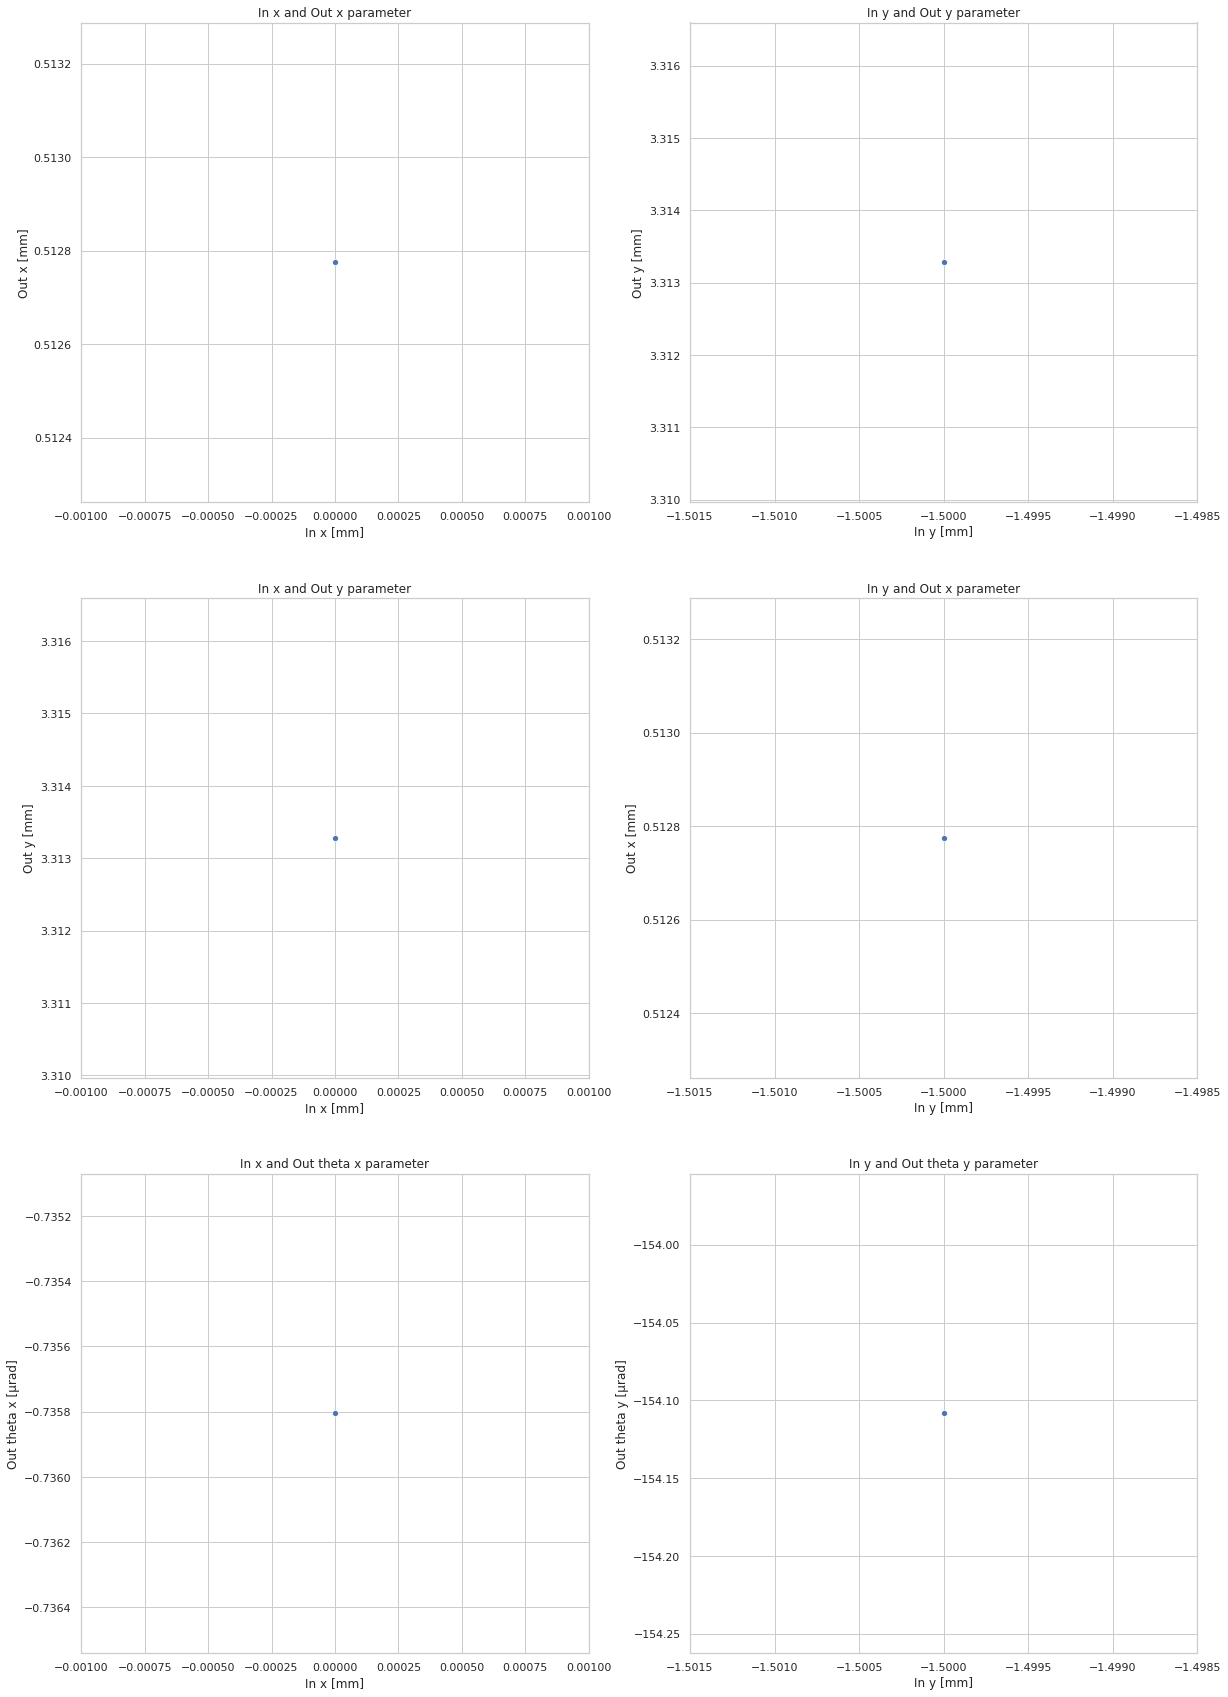

In [10]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot("x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("x", "y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("y", "x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

plot("x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 2, 0)

plot("y", "theta y", "In ", "Out ",  input_matrix, output_matrix, axes, 2, 1)

/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=150.0, right=150.0
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.7358056590643, top=-0.7358056590643
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-154.10844323639998, top=-154.10844323639998
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarn

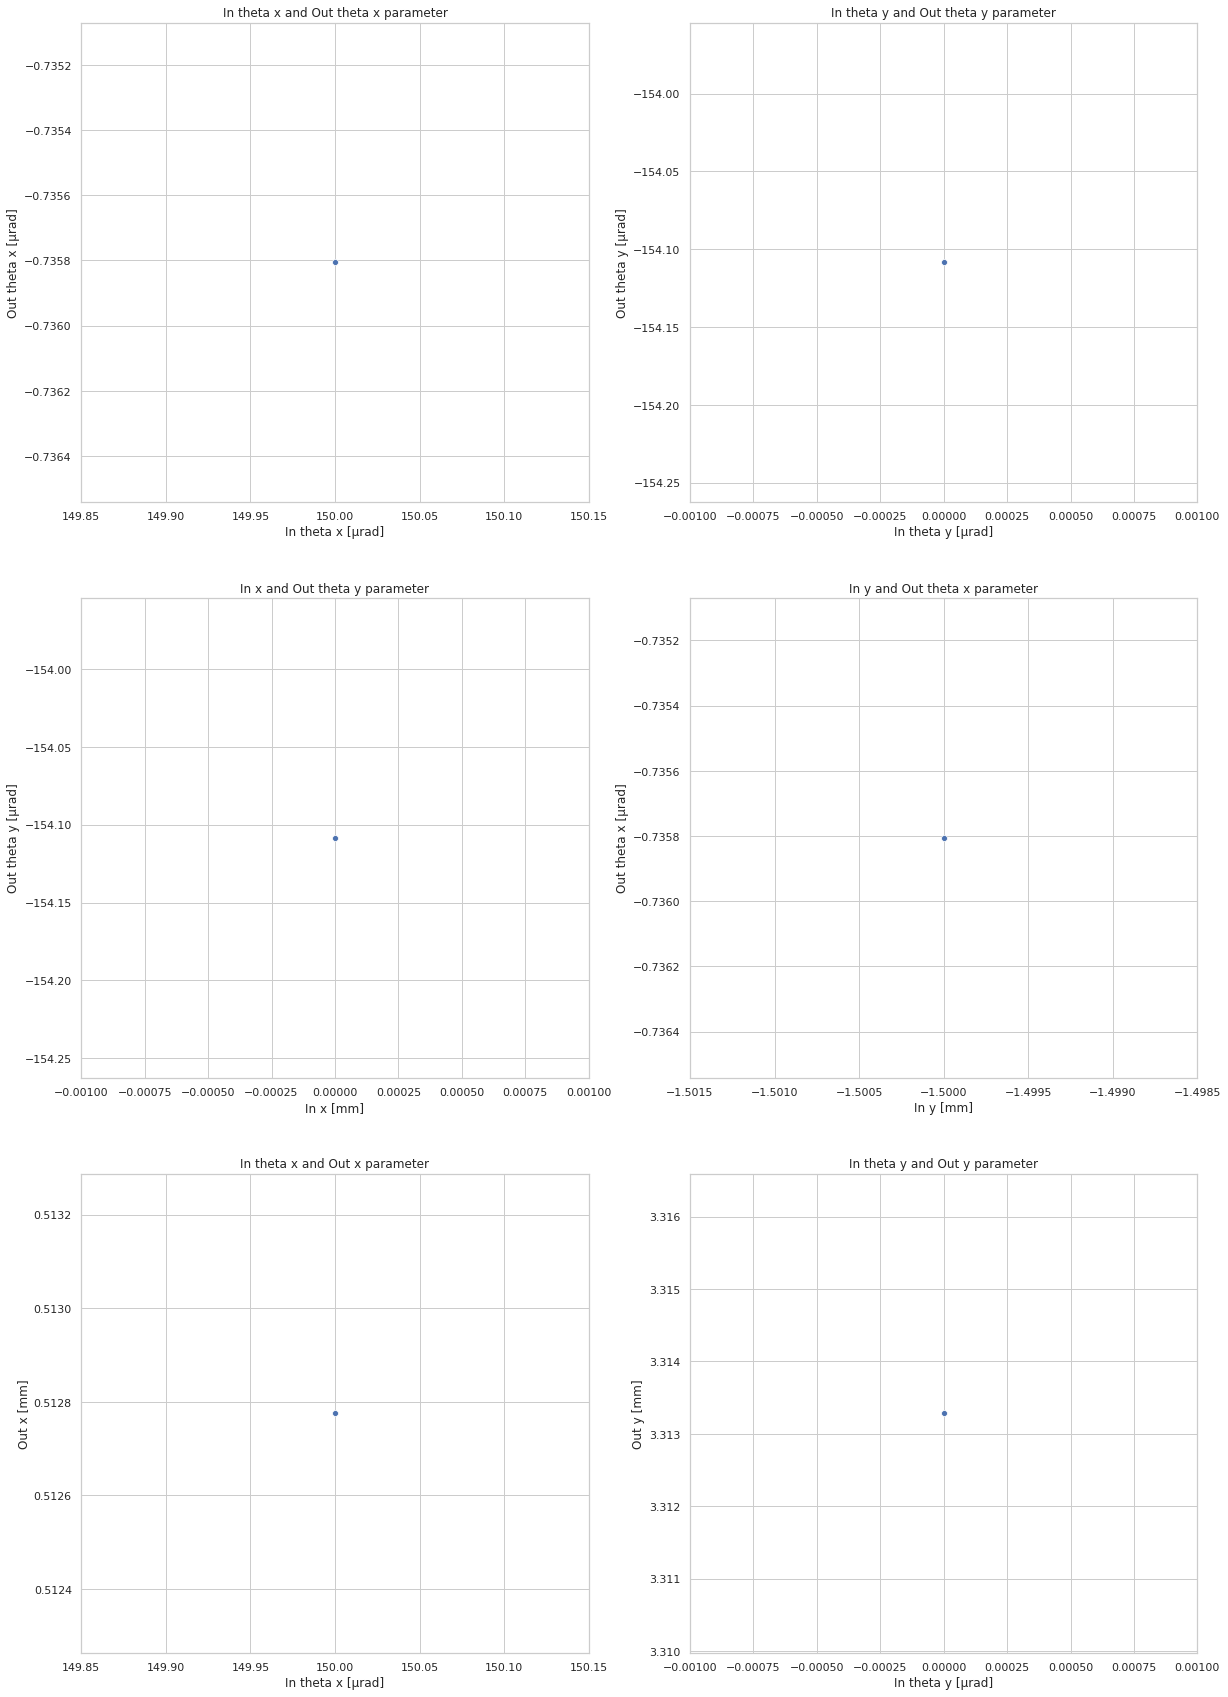

In [11]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot("theta x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("theta y", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("x", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("y", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

plot("theta x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 2, 0)

plot("theta y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 2, 1)


/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.006767082648165, right=-0.006767082648165
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.006767082648165, top=-0.006767082648165
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.313280832108, top=3.313280832108
/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.5127751102877001, top=0.5127751102877001


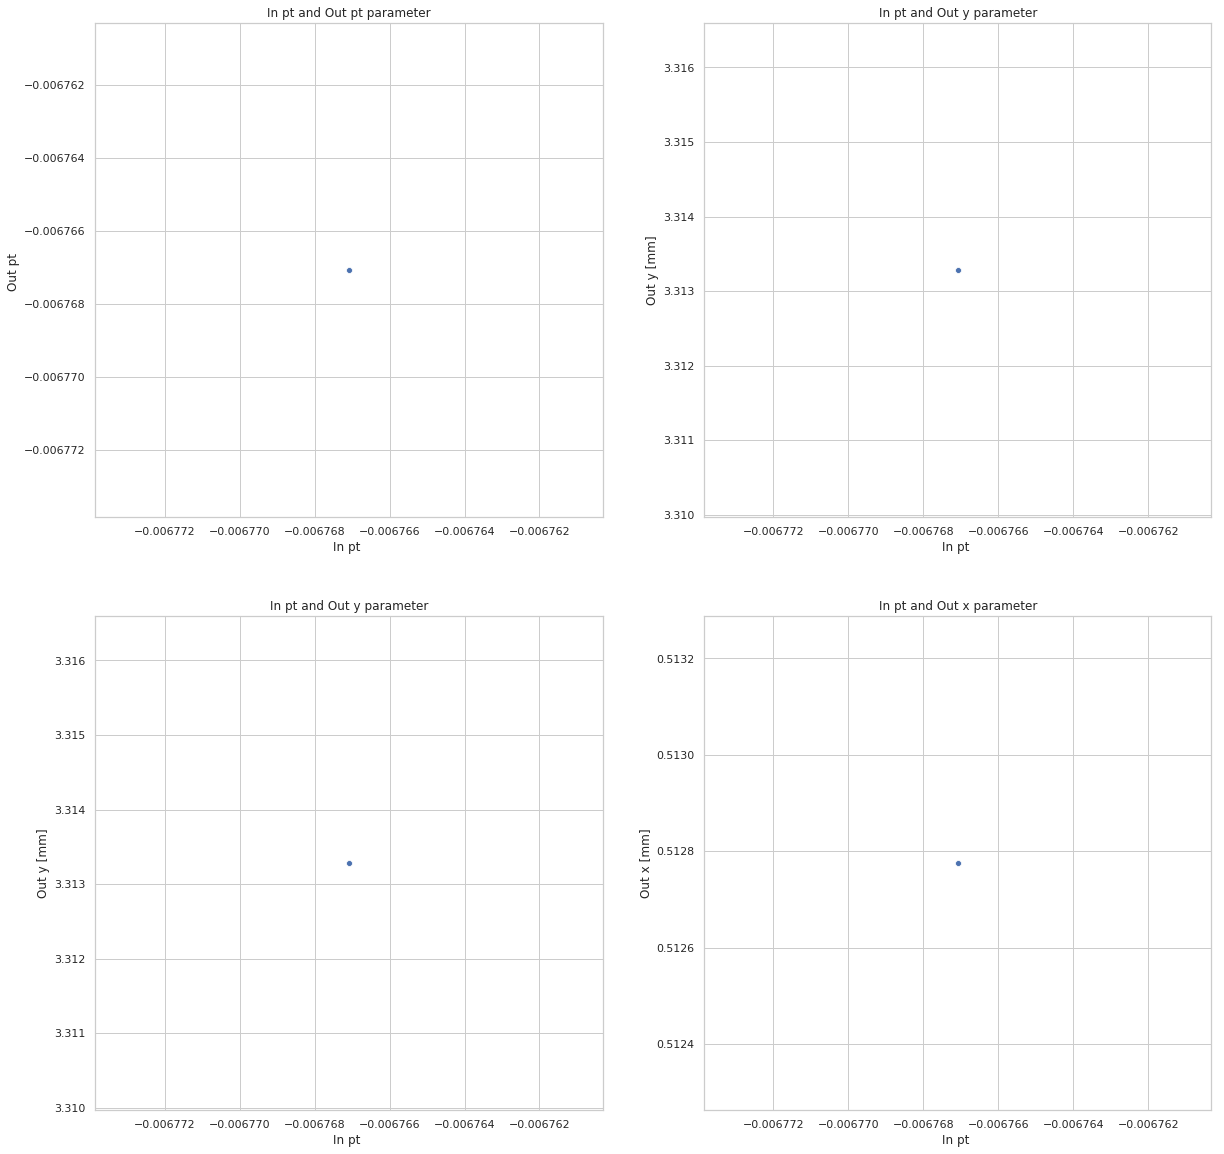

In [12]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot("pt", "pt", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("pt", "y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("pt", "y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("pt", "x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

In [13]:
output_matrix.shape

(1, 10)

In [14]:
non_filtered_input_matrix.shape

(1, 10)